In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
 
# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import nibabel as nib
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import numpy as np
import os

from keras import backend
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Activation, GlobalAveragePooling2D, Dense
from keras.layers import Input, Conv2D, ZeroPadding2D, BatchNormalization
from keras.models import Model
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.preprocessing.text import one_hot
from keras.preprocessing.text import text_to_word_sequence
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.utils import to_categorical


Using TensorFlow backend.


In [2]:
base_model = ResNet50(weights="imagenet", include_top=False,
              input_tensor=Input(shape=(190, 158, 3)))

for layer in base_model.layers:
    layer.trainable = False

for layer in base_model.layers[-5:]:
    layer.trainable = True

/home/ben/.local/lib/python3.5/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [3]:
# Add layer to change output dims
# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- 3 classes
predictions = Dense(3, activation='softmax')(x) 
model = Model(inputs=base_model.input, outputs=predictions)

In [4]:
# Get data csv (Subject, Group)
patientData = np.loadtxt("ADNI1_Complete_1Yr_1.5T_10_26_2019.csv", 
                         dtype= 'str', skiprows=1, delimiter=',')

# One Hot Encode
num_cats = 3

# integer encode the document
integer_mapping = {x: i for i,x in enumerate(['AD', 'MCI', 'CN'])}
y = np.asarray([integer_mapping[word] for word in patientData[:,1]])
labels = to_categorical(y, num_classes=num_cats, dtype='float32')

print(integer_mapping)
#print(labels[0:5,:])
#print(patientData[0:5,:])

subject = patientData[1,0]
cat = patientData[1,1]


{'AD': 0, 'CN': 2, 'MCI': 1}


In [5]:
def show_slices(slices):
    """ Function to display row of image slices """
    fig, axes = plt.subplots(1, len(slices))
    for i, slice in enumerate(slices):
        axes[i].imshow(slice.T, cmap="gray", origin="lower")

In [6]:
def viewSlides(filename):
    epi_img = nib.load('./ADNI_Clean/'+filename)
    # Get voxel array
    epi_img_data = epi_img.get_fdata()
    n_i, n_j, n_k = epi_img_data.shape
    print(epi_img_data.shape)

    c0 = (n_i - 1) // 2  # // for integer division
    c1 = (n_j - 1) // 2
    c2 = (n_k - 1) // 2

    slice_0 = epi_img_data[c0,c1-95:c1+95,c2-79:c2+79]
    slice_1 = epi_img_data[c0-95:c0+95:,c1,c2-79:c2+79]
    slice_2 = epi_img_data[c0-95:c0+95,c1-79:c1+79,c2]
    show_slices([slice_0, slice_1, slice_2])
    plt.suptitle("Center slices for EPI image")


(256, 256, 170)


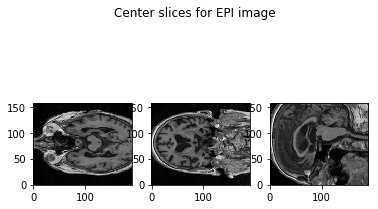

In [7]:
viewSlides("012_S_0720_.nii")

In [8]:
def getImageSlice( sliceInt, subject, directory ):
    # Formatted to input 3 slices input NN
    epi_img = nib.load(directory + subject + '.nii')
    # Get voxel array
    epi_img_data = epi_img.get_fdata()
    n_i, n_j, n_k = epi_img_data.shape

    c0 = (n_i - 1) // 2  # // for integer division
    c1 = (n_j - 1) // 2
    c2 = (n_k - 1) // 2
    
    if sliceInt == 0:
        sliceArr = epi_img_data[c0,c1-95:c1+95,c2-79:c2+79]
    elif sliceInt == 1:
        sliceArr = epi_img_data[c0-95:c0+95:,c1,c2-79:c2+79]
    else: 
        sliceArr = epi_img_data[c0-95:c0+95,c1-79:c1+79,c2]

    return sliceArr

In [9]:
def buildDataSet( directory, patientData, sliceInt0, sliceInt1, sliceInt2, labels ):
    
    for i, filename in enumerate(os.listdir(directory)):
        subject = filename[:-4]

        slice_0 = getImageSlice(sliceInt0, subject=subject, directory=directory)
        slice_1 = getImageSlice(sliceInt1, subject=subject, directory=directory)
        slice_2 = getImageSlice(sliceInt2, subject=subject, directory=directory)
        
        x0 = np.expand_dims(slice_0, axis=2)
        x1 = np.expand_dims(slice_1, axis=2)
        x2 = np.expand_dims(slice_2, axis=2)

        x = np.concatenate((x0, x1, x2), axis = 2)
        x = np.expand_dims(x, axis=0)

        ind = np.where(patientData[:,0] == subject[:-1])[0][0]
        y = labels[ind, :] 
        y = y.reshape(1,-1)

        
        if i == 0:
            X = x
            Y = y
        else:
            X = np.concatenate((X,x), axis = 0)
            Y = np.concatenate((Y,y), axis = 0)
        
    return X, Y
    

In [10]:
X,Y = buildDataSet(directory = "./ADNI_Clean/",patientData, 0, 1, 2, labels = labels )
print(Y.shape)
print(X.shape)


(54, 3)
(54, 190, 158, 3)


In [11]:
# compile the keras model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [17]:
X = preprocess_input(X)
# fit the keras model on the dataset
history = model.fit(X, Y, epochs=15, batch_size=2, verbose = 2, validation_split = 0.2, shuffle=True)

Train on 43 samples, validate on 11 samples
Epoch 1/15
 - 3s - loss: 0.6147 - accuracy: 0.7442 - val_loss: 6.2271 - val_accuracy: 0.3636
Epoch 2/15
 - 3s - loss: 0.4017 - accuracy: 0.8605 - val_loss: 12.1573 - val_accuracy: 0.2727
Epoch 3/15
 - 3s - loss: 0.1757 - accuracy: 0.9302 - val_loss: 6.3429 - val_accuracy: 0.5455
Epoch 4/15
 - 3s - loss: 0.1446 - accuracy: 0.9767 - val_loss: 10.4865 - val_accuracy: 0.3636
Epoch 5/15
 - 3s - loss: 0.0983 - accuracy: 0.9535 - val_loss: 7.3364 - val_accuracy: 0.2727
Epoch 6/15
 - 3s - loss: 0.1362 - accuracy: 0.9535 - val_loss: 12.7875 - val_accuracy: 0.3636
Epoch 7/15
 - 3s - loss: 0.1810 - accuracy: 0.9535 - val_loss: 11.3942 - val_accuracy: 0.3636
Epoch 8/15
 - 3s - loss: 0.1963 - accuracy: 0.9070 - val_loss: 4.8310 - val_accuracy: 0.5455
Epoch 9/15
 - 3s - loss: 0.1800 - accuracy: 0.9767 - val_loss: 11.2214 - val_accuracy: 0.2727
Epoch 10/15
 - 3s - loss: 0.1475 - accuracy: 0.9767 - val_loss: 7.0875 - val_accuracy: 0.5455
Epoch 11/15
 - 3s - 

In [18]:
X_train,Y_train = buildDataSet(directory = "./ADNI_Test/",patientData, 0, 1, 2, labels = labels )
_, accuracy = model.evaluate(X_train, Y_train)
print('Accuracy: %.2f' % (accuracy*100))

54/54 [==============================] - 2s 41ms/step
Accuracy: 42.59


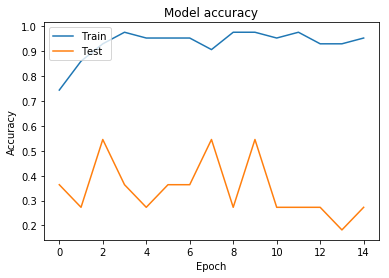

In [19]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

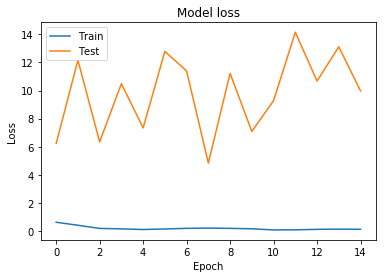

In [20]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()